In [59]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap

import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')


In [60]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()
    

In [83]:
def average_speakers(mfcc_df):
    
    feature_cols = [x for x in mfcc_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'phoneme'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined, feature_cols


def load_data():
    train = pd.read_csv('../../../data/train_formants_phonemes.csv')
    test = pd.read_csv('../../../data/test_formants_phonemes.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
#     train, feature_cols = average_speakers(train)
    
    british_df = pd.read_csv('../../../data/british_formants_phonemes.csv')
    feature_cols = [x for x in british_df.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]
    
    return train, test, british_df[feature_cols], feature_cols


train, test, british_df, feature_cols = load_data()

In [105]:
def xgb_me(train, test, display_conf=True, word = None, accents=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if x in ('f1', 'f2', 'f3', 'f4', 'f5', 'bw1', 'bw2', 'bw3', 'bw4', 'bw5')]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

    X_test = test[feature_cols]
    y_test = test['accent']
        
    x_boost = xgb.XGBClassifier(max_depth=8)
    x_boost.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                eval_metric='logloss', verbose=True, early_stopping_rounds=10)
    
    y_pred = x_boost.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"XGBoost accuracy: {acc}")
        print(f"XGBoost number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return x_boost, y_pred, conf_df, classification_report(y_test, y_pred), acc


# x_boost_whole, x_boost_pred_whole, x_boost_conf_whole, x_boost_mat_whole, acc = xgb_me(train, test)

In [104]:
british_pred = x_boost_whole.predict(british_df)

whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])
whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR1    39741
DR7    37376
DR5    34145
DR6    31996
DR3    28958
DR4    22401
DR2    11295
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,39741,19.299992
DR2,11295,5.485353
DR3,28958,14.063289
DR4,22401,10.878919
DR5,34145,16.582326
DR6,31996,15.538677
DR7,37376,18.151443


In [97]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test



In [98]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_train.head()

,accent,gender,phoneme,word,recording,speaker,duration,f1,f2,f3,...,mfcc_median_4,mfcc_median_5,mfcc_median_6,mfcc_median_7,mfcc_median_8,mfcc_median_9,mfcc_median_10,mfcc_median_11,mfcc_median_12,region
0,Mid,f,aa,abolish,SX421,FJLR0,0.134500,892.650932,1346.873042,3600.668025,...,-99.694111,36.314608,9.591187,-33.233897,-11.064189,-0.204870,-21.507598,-21.735954,-13.546655,Mid
1,West,f,aa,abolish,SX421,FKDE0,0.135500,879.260056,1007.877368,3397.359130,...,-119.597659,57.970350,-2.063463,-14.893880,-36.864311,18.835948,-29.443554,-0.525257,-21.695353,West
2,North,m,aa,abolish,SX421,MABC0,0.088688,824.390468,1110.621656,3344.068102,...,-110.667987,-26.131835,30.497241,-24.852131,0.539529,-4.421552,16.669588,16.086130,-39.082641,North
3,Mid,m,aa,abolish,SX421,MGAG0,0.084812,863.658073,1288.645646,3912.952466,...,-93.242437,3.730850,11.649659,5.808547,-3.850258,-34.845298,37.643081,-8.135744,-29.098650,Mid
4,South,m,aa,abolish,SX421,MPMB0,0.100000,961.803179,1788.983942,3186.045272,...,-69.762314,0.807939,67.126599,-16.932932,-14.914250,6.321771,0.602284,-16.578040,-17.155976,South


[0]	validation_0-mlogloss:1.38696
[1]	validation_0-mlogloss:1.38783
[2]	validation_0-mlogloss:1.38889
[3]	validation_0-mlogloss:1.38954


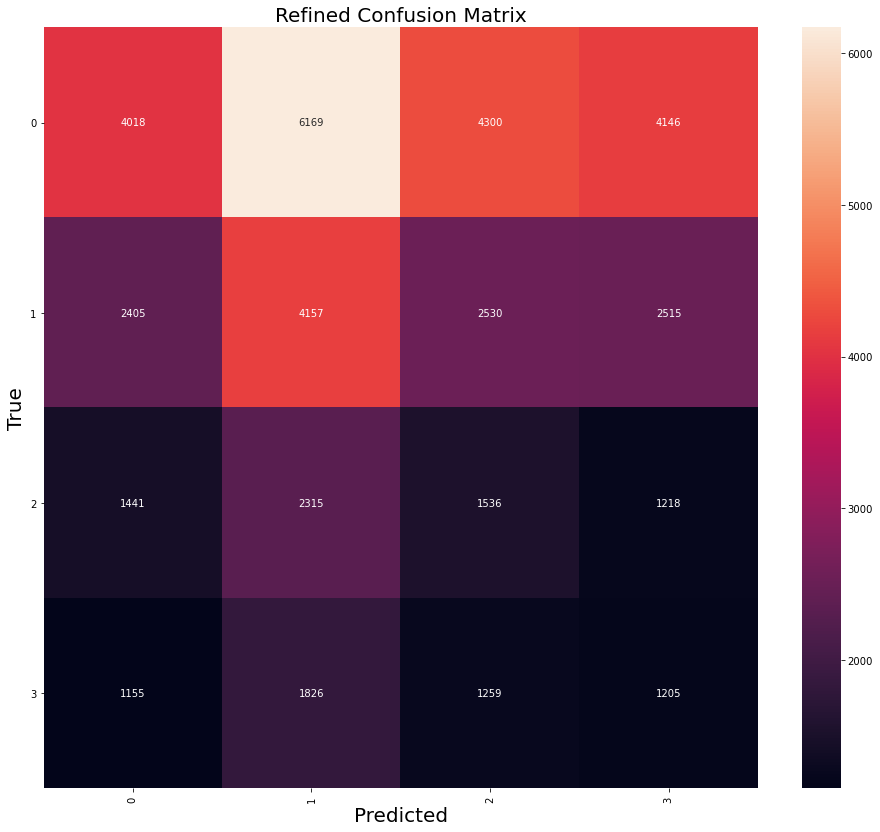

XGBoost accuracy: 0.25870363787178574
XGBoost number of mislabeled points out of a total 42195 points : 31279
                    Mid         North        South         West  accuracy  \
precision      0.445504      0.287344     0.159584     0.132651  0.258704   
recall         0.215639      0.358146     0.235945     0.221304  0.258704   
f1-score       0.290612      0.318862     0.190394     0.165875  0.258704   
support    18633.000000  11607.000000  6510.000000  5445.000000  0.258704   

              macro avg  weighted avg  
precision      0.256271      0.317513  
recall         0.257758      0.258704  
f1-score       0.241436      0.266824  
support    42195.000000  42195.000000  


In [99]:
condensed_x_boost, condensed_x_boost_pred, condensed_x_boost_conf, condensed_x_boost_mat, condensed_acc = xgb_me(condensed_train, condensed_test)

In [100]:
british_pred = condensed_x_boost.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)




North    72254
West     54999
South    44364
Mid      34295
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,34295,16.655173
North,72254,35.089747
South,44364,21.545126
West,54999,26.709954


In [101]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    129774
West     27798
Name: accent, dtype: int64

[0]	validation_0-logloss:0.69101
[1]	validation_0-logloss:0.69073
[2]	validation_0-logloss:0.69039
[3]	validation_0-logloss:0.68954
[4]	validation_0-logloss:0.68923
[5]	validation_0-logloss:0.68877
[6]	validation_0-logloss:0.68824
[7]	validation_0-logloss:0.68783
[8]	validation_0-logloss:0.68741
[9]	validation_0-logloss:0.68701
[10]	validation_0-logloss:0.68673
[11]	validation_0-logloss:0.68626
[12]	validation_0-logloss:0.68599
[13]	validation_0-logloss:0.68582
[14]	validation_0-logloss:0.68566
[15]	validation_0-logloss:0.68551
[16]	validation_0-logloss:0.68462
[17]	validation_0-logloss:0.68449
[18]	validation_0-logloss:0.68433
[19]	validation_0-logloss:0.68403
[20]	validation_0-logloss:0.68388
[21]	validation_0-logloss:0.68331
[22]	validation_0-logloss:0.68277
[23]	validation_0-logloss:0.68251
[24]	validation_0-logloss:0.68198
[25]	validation_0-logloss:0.68197
[26]	validation_0-logloss:0.68134
[27]	validation_0-logloss:0.68126
[28]	validation_0-logloss:0.68034
[29]	validation_0-loglos

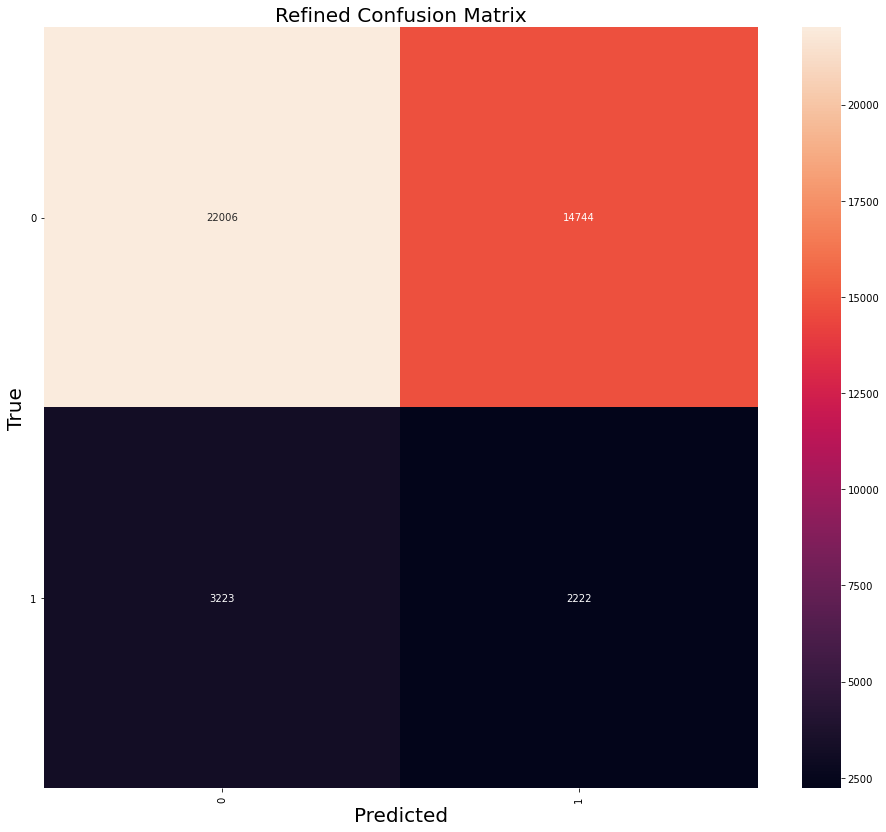

XGBoost accuracy: 0.5741912548880199
XGBoost number of mislabeled points out of a total 42195 points : 17967
                   East         West  accuracy     macro avg  weighted avg
precision      0.872250     0.130968  0.574191      0.501609      0.776592
recall         0.598803     0.408081  0.574191      0.503442      0.574191
f1-score       0.710111     0.198295  0.574191      0.454203      0.644065
support    36750.000000  5445.000000  0.574191  42195.000000  42195.000000


In [106]:
cm_x_boost, cm_x_boost_pred, cm_x_boost_conf, cm_x_boost_mat, cm_acc = xgb_me(condensed_train_two_regions, condensed_tes_two_regions)

In [107]:
british_pred = cm_x_boost.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    127694
West     78218
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,127694,62.01387
West,78218,37.98613
